### Canada's Response to Economic Impacts of COVID-19
  
Amanda Cheney  
Metis Final Project  
Part 4 of 4  
December 8, 2020    

**Objective**  
Unsupervised learning and natural language processing to identify two sets of clusters of Twitter conversations about the Canadian Emergency Response Benefit (CERB) and Canadian Recovery Benefit (CRB) programs to address unemployment and economic impacts of the COVID-19 pandemic. 

1. One that captures the contours of everyday user conversations. 

2.  Another that highlights clusters of conversation that are really, really dense, have users make collaborative efforts to shape public opinion and perception.  

**Data Sources**  
250,000+ tweets from March 1 - December 1, 2020, collected using snscrape.  

**This Notebook**  
Uses KMeans to identify clusters in 93% of tweets unclassified by HDBSCAN. My intention is now for KMeans to give me a basic overview of the general clusters of conversation among everday users, note that I use KMeans rather than HDBSCAN, as in a previous iteration, over ninety percent of the data was again unclassified, so KMeeans will be a better choice as it ensures that all data will be clustered.

## Imports

In [1]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

import pandas as pd
import pickle
import numpy as np

# Visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt


# Avoid warnings
import warnings
warnings.filterwarnings("ignore")

from collections import Counter
from sklearn.manifold import TSNE

from sklearn.metrics import silhouette_score, silhouette_samples

## Load Data

In [2]:
with open('unclassified_dvs.pickle', 'rb') as read_file:
    doc_vectors = pickle.load(read_file)

In [3]:
len(doc_vectors)

223375

## KMeans parameters

To select the optimal number of clustesr, I use Yellowbrick's KElbowVisualizer.

In [4]:
X = doc_vectors 

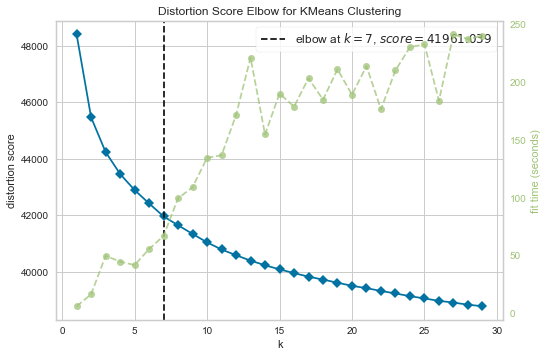

CPU times: user 3h 24min 35s, sys: 5min 38s, total: 3h 30min 13s
Wall time: 1h 14min 13s


<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [5]:
%%time
# Instantiate the clustering model and visualizer
model = KMeans(n_jobs=-1)
visualizer = KElbowVisualizer(model, k=(1,30))

visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure


Let's cross compare with the optimal number we might infer from the silhouette scores.

In [10]:
from sklearn.metrics.cluster import silhouette_score

In [15]:
%%time
silhouette_scores = []
for cluster in np.arange(2,30):
    km = KMeans(n_clusters=cluster).fit(doc_vectors)
    silhouette_scores.append(silhouette_score(doc_vectors, km.labels_))

In [ ]:
# with open('6_kmeans_silhouette_scores_on_hdbscan_noise.pickle', 'wb') as to_write:
#     pickle.dump(silhouette_scores, to_write)

In [337]:
with open('6_kmeans_silhouette_scores_on_hdbscan_noise.pickle', 'rb') as read_file:
    silhouette_scores = pickle.load(read_file)

In [361]:
sns.set_style('whitegrid', {"xtick.major.size": 4, "ytick.major.size": 4})
# sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})

Text(0, 0.5, 'silhouette score')

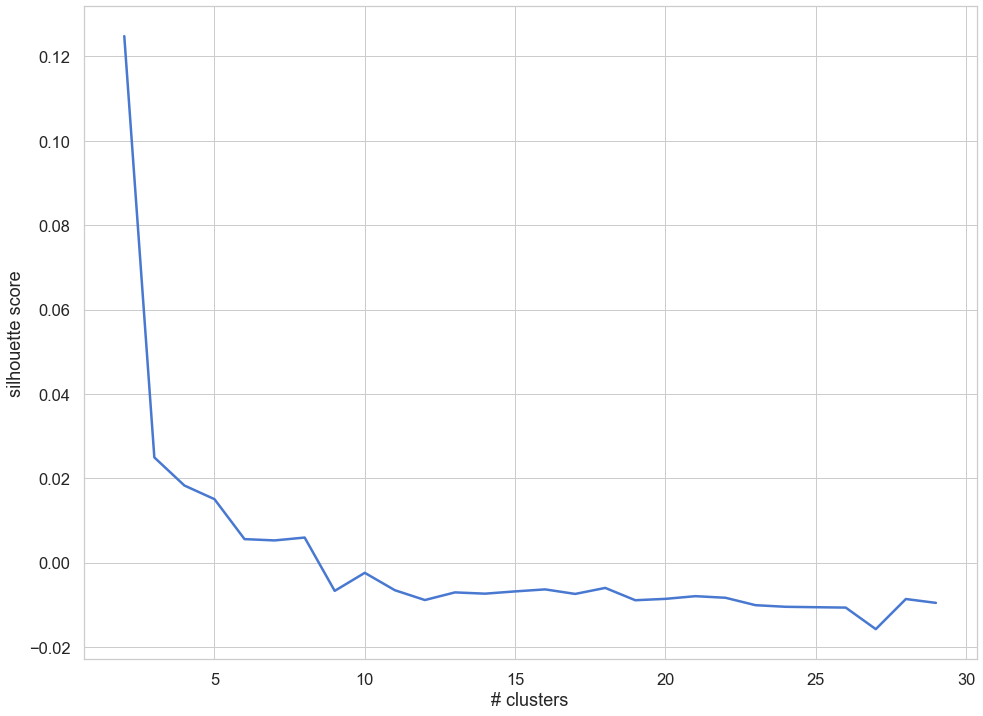

In [363]:
plt.figure(figsize=(16,12))
sns.mpl.pyplot.plot(np.arange(2,30), silhouette_scores)
sns.mpl.pyplot.xlabel("# clusters")
sns.mpl.pyplot.ylabel("silhouette score")

It looks like k=7 is the optimal number based on both the inertias and silhouette scores. Now to fit the model.

In [7]:
km = KMeans(n_clusters=7)

In [9]:
%%time
km_x_topics = km.fit(doc_vectors)

CPU times: user 3min 35s, sys: 6.07 s, total: 3min 41s
Wall time: 1min 18s


Add Kmeans labels to DF

In [10]:
with open('unclassified_hdbscan_100_15.pickle', 'rb') as read_file:
    df1 = pickle.load(read_file)

In [12]:
df1['km_label'] = km.labels_

In [14]:
cluster_sizes=Counter(km.labels_)

In [15]:
print(cluster_sizes)

Counter({4: 80947, 6: 65255, 3: 32986, 5: 22015, 1: 11303, 2: 6829, 0: 4040})


In [16]:
km7_cluster_centers = km.cluster_centers_

In [17]:
with open('km7_cluster_centers.pickle', 'wb') as to_write:
    pickle.dump(km7_cluster_centers, to_write)

In [191]:
with open('km_hdb_noise_df_w_labels.pickle', 'wb') as to_write:
    pickle.dump(df1, to_write)

In [202]:
df1.columns

Index(['index', 'url', 'date', 'content', 'renderedContent', 'id', 'user',
       'outlinks', 'tcooutlinks', 'replyCount', 'retweetCount', 'likeCount',
       'quoteCount', 'conversationId', 'lang', 'source', 'sourceUrl',
       'sourceLabel', 'media', 'retweetedTweet', 'quotedTweet',
       'mentionedUsers', 'user_name', 'simple_date', 'location', 'no_user',
       'clean', 'hashtags', 'clean_split', 'list_vader_scores', 'compound',
       'vader_score', 'spacy_doc', 'for_vecs', 'hdb_label', 'km_label'],
      dtype='object')

# Visualizing the clusters and their separability

Now let's visualize the clusters and how separable they are using TSNE.

In [446]:
clusters_embedded = TSNE(n_components=2, early_exaggeration=10, learning_rate=200, perplexity=5, n_iter=300, random_state=44).fit_transform(km.cluster_centers_)

In [451]:
psuedo_labels =[0, 1, 2, 3, 4, 5, 6]

In [453]:
x = [i[0] for i in clusters_embedded]
y = [i[1] for i in clusters_embedded]

Text(0, 0.5, 'tSNE dimension 2')

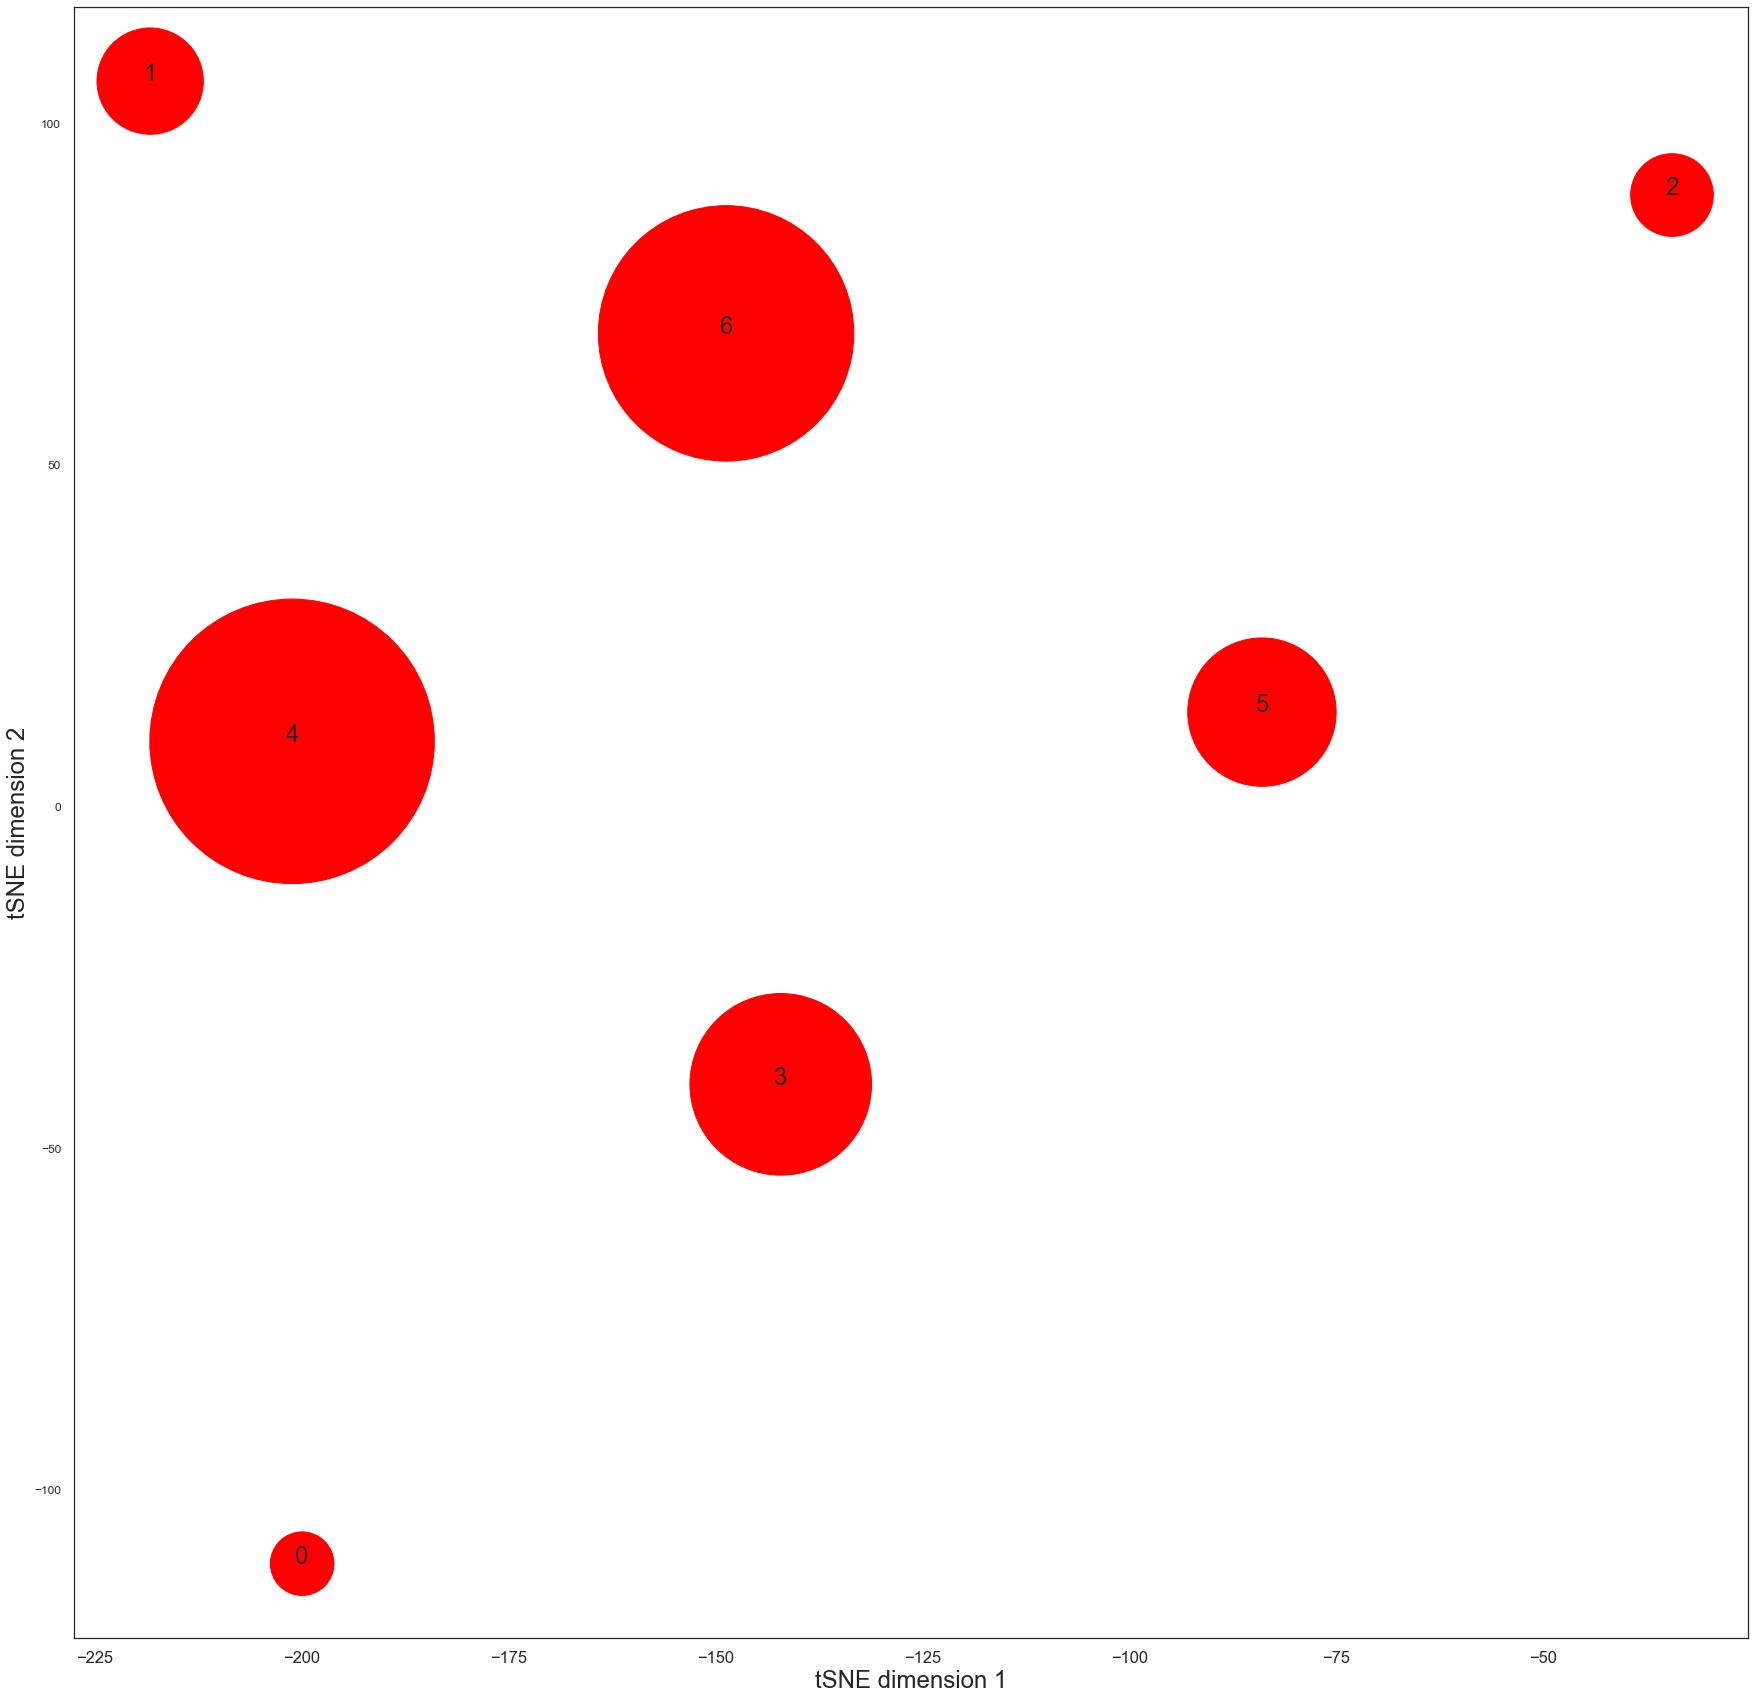

In [454]:
sns.set_style("white")
cluster_sizes = pd.Series(Counter(km.labels_)).sort_index()

plt.figure(figsize=(30,30))
plt.scatter(x,y, 
            c = 'red',
            s=cluster_sizes)
i=-1
for x_lab,y_lab in zip(x,y):
    i +=1
    plt.annotate(psuedo_labels[i],(x_lab,y_lab), ha="center", fontsize=24)

plt.xlabel('tSNE dimension 1',fontsize=24)
plt.ylabel('tSNE dimension 2', fontsize=24)

# Interpretation of Clusters

In [135]:
filtered_docs = [str(doc.sum()) != 'nan' for doc in doc_vectors]

In [136]:
docs_for_df = np.array(df1['clean'])[filtered_docs]

In [137]:
tw_labels = pd.DataFrame({'tweet': docs_for_df, 'label':km.labels_})

In [138]:
tw_labels.head()

,tweet,label
0,In our Entire extended family only one Niece l...,4
1,Many Canadians dont realize this Look at the s...,4
2,So that wont cost me taxes for cerb payments f...,1
3,False The NUMBER ROLE OF GOVT is to PROTECT TH...,3
4,Something like over million was mistakenly sen...,6


To interpret the labels of the clusters of embeddings, for each cluster, take the cluster center then find the 10 documents closest to it. 

In [488]:
just_one = df1[df1['clean']=='CERB EXTENTIONOn June  the government announced it will extend the Canada Emergency Response Benefit CERB for another weeks to provide support for a total of weeks ending October  ']
just_one

,index,url,date,content,renderedContent,id,user,outlinks,tcooutlinks,replyCount,...,hashtags,clean_split,list_vader_scores,compound,vader_score,spacy_doc,for_vecs,hdb_label,km_label,month
126718,134632,https://twitter.com/brianne_gardner/status/127...,2020-06-19 16:45:02+00:00,"CERB EXTENTION***On June 16, 2020, the governm...","CERB EXTENTION***On June 16, 2020, the governm...",1274020374242627585,"{'username': 'brianne_gardner', 'displayname':...",[https://www.rjsocialmedia.com/tcct36],[https://t.co/PWXgMOqS17],0,...,[],"[CERB, EXTENTIONOn, June, the, government, ann...","{'neg': 0.076, 'neu': 0.706, 'pos': 0.218, 'co...",0.5859,Positive,"(CERB, EXTENTIONOn, June, , the, government, ...","[CERB, EXTENTIONOn, June, , the, government, ...",-1,0,6


`find_closest` function drawn from https://stackoverflow.com/questions/26795535/output-50-samples-closest-to-each-cluster-center-using-scikit-learn-k-means-libr

In [504]:
def find_closest(doc_vectors, km):
    master_lists = []
    for i in range(len(km.cluster_centers_)):
        d = km.transform(doc_vectors)[:, i]
        ind = np.argsort(d)[::][:10]
        int_list = [tw_labels.iloc[j].tweet for j in ind]
        master_lists.append([ind, int_list])
    return master_lists

In [506]:
%%time
cluster_top_10s = find_closest(doc_vectors, km)

CPU times: user 9.73 s, sys: 2.55 s, total: 12.3 s
Wall time: 7.86 s


In [141]:
with open('km_7_cluster_top_10s.pickle', 'wb') as to_write:
    pickle.dump(cluster_top_10s, to_write)

Cluster 0 looks to be about CERB extension

In [507]:
cluster_top_10s[0]

[array([121106, 207858, 188035, 200666, 123250, 112752, 117728,  80078,
        147079, 153080]),
 ['CERB UPDATE  The Canadian Emergency Response Benefit CERB will be extended from a maximum of weeks to weeks  If you have lost income due to COVID you can apply for CERB at  covidupdate canada cerb ',
  'Latest number from Canadian government Monday alone  Canadians applied for the CERB Since March th  million Canadians have applied for help Employment insurance or other So far the government has processed just over million claims cdnpoli COVID',
  ' We announced improvements to the CERB Expanded the eligibility to allow folks to earn up to mth while collecting CERB Extended CERB to workers who exhausted their EI reg benefits between Dec  amp Oct  amp cant return to work because of COVID ',
  'Canada Emergency Response Benefit CERB is available for the period of March  to October  for individuals who lost their income as a result of COVID There is information for international and domest

Cluster 1 looks to be about people experiencing financial problems

In [508]:
cluster_top_10s[1]

[array([116190, 200600, 156306, 110430,  22534, 109590, 114516,  51488,
        206045, 166928]),
 ['Whats up with the cerb commentary Sooo because of corona ppl shouldnt collect the money they couldve potentially made at work Your mother gets cerb so dont come on twitter and front I would gladly take your cerb money since your hiding it',
  'I heard about the double pay Because online its says there was an option to also forward your application from ei to cerb One of my friend thats super greedy works jobs and still got cerb ontop Its like yoo they need to slow down and investigate each application',
  'Stay on cerb it looks like if u get CERB at all youre automatically going to be ineligible for all payments of CESB Theyll take off a month from odsp clawbacks the big problem is if u dont qualify for cerb then u wont get CESB and be forced to pay cerb back',
  'Having no money for Canada Day after cerb ran out and no money for a month cant even get Ontario works cause of cerb cant ev

Cluster 2 looks to be a lot of announcements related to the program.

In [509]:
cluster_top_10s[2]

[array([ 88570,  88568, 193592,  52828, 206520, 167197,  44491, 221168,
         39058, 216484]),
 ['SCAM AlERT CERB does not send E Transfers Hi CRA and CERB Changes to Canada Revenue Agency services as affected by the pandemic Instant Deposit System for the Canada Emergency Response Benefit CERB CRA CERB sent you CAD on July ',
  'SCAM AlERT CERB does not send E Transfers Hi CRA and CERB Changes to Canada Revenue Agency services as affected by the pandemic Instant Deposit System for the Canada Emergency Response Benefit CERB CRA CERB sent you CAD on July ',
  'Summary COVID pandemic impact across Canada Thanks for offer CERB Kmons for four months Both CERB and ON Social Service Policy are conflicts BC Govt allow BC Deaf and Disability to obtain CERB Different CERB is federal fund Provincials coffers UBI',
  'Hey YangGang WAKE UP Canada needs your help NOW CERB is trending in Canada Please retweet the phrase CERBgtUBI Turn the Canada Emergency Response Benefit CERB into a permanent Un

Cluster 3 seems to be concerned with inequalies in the economic impacts of COVID and how CERB may not be addressing these fairly.

In [510]:
cluster_top_10s[3]

[array([ 22841, 180836,  69666,  72552,  25578, 220712,  48349,  44545,
          7275,  67139]),
 ['Canadas Covid Emergency Reponse Benefit program has ended and Canadians on disability pensions still havent seen the one time payment the government said they were authorizing back in June Disability pensions pay HALF of what was deemed necessary for CERB',
  'An important update for ODSP and OW recipients who have lost their jobs due to COVID The Ford government will be treating CERB payments as earned income despite the federal gvt asked all provinces to exempt CERB benefits from any clawbacksygk onpoli ',
  'Women and lowwage racialized workers in precarious employment are hit the hardest by COVID job losses For these households CERB was financial lifeline With CERB ending do you think the new EI program will be enough to live on onlab andFairness ',
  'In March millions of Canadians found themselves without an income as the economy shut down in response to COVID Those who qualified 

Cluster 4 seems to discuss tensions that exist between business interests and public welfare.

In [511]:
cluster_top_10s[4]

[array([215116, 124368, 135192, 107668,  33955, 144978,   4725, 117533,
         79047,  60229]),
 ['Its funny that after admitting the hold up on CERB was entirely about the oil industry and the carbon tax conservative MPs amp MPPs seem to have a burr in thier bum now that not all Canadians affected or otherwise qualify for CERB The story changes daily',
  'I dont think extending an existing program counts as voted for new aid Interesting that when CEWS was x the budget of CERB Trudeau was quick to double it for his corporate buddies over a month ago But unemployed people pinch pennies waiting for him to extend the CERB ',
  'A guess Disability is for one person only If you have dependents there are other programmes to pump that up CERB accounts for the expenses of an average Canadian with a bit more means poss a kid If we all get kicked out of our homes have change citiesjobs were Fed',
  'We are at War somehow the CPC can not equate the cost of doing bussiness with what must be done

Cluster 5 seems to discuss CERB blindspots, excluded parties and how it has ended up acting as a wage subsidy.

In [512]:
cluster_top_10s[5]

[array([158264,  38638,  22599, 135747,  29276,  99817, 165808, 137721,
         81617,  86363]),
 ['Mr Trudeau I havent left my apartment for weeks I am cooperating But no CERB for me Wheres the CERB money for me Are those people in the video collecting CERB They arent cooperating How about taking away their CERB and giving it to me',
  'I must be blind today sorry Can you highlight the mention of CERB specifically A new benefit would not be CERB CEWS is not CERB You run with the headline CERB Extended your the only new source in Canada stating that',
  'Realistically CERB or a better benefit should stay in place until there is a cure Bills are due now moreso than later and thats if we live And that is equivalent to at least months of CERB payments CERB Update Will the CRA Extend the CERB ',
  'No one begrudges anyone for receiving CERB What irks people is when their job calls them back and theyd rather stay on CERB My Son cant get bar workers to return to work because of CERB I feel 

Cluster 6 seems mainly concerned with the question of CERB fraud.

In [513]:
cluster_top_10s[6]

[array([  7742,  63204,  19213, 125708, 205733, 141635, 154349, 188791,
         86118, 192150]),
 ['So I just got a call from Revenue Canada looking for my son to verify his eligibility for CERB at the time So I said to her maybe you should be tracking down those people who hadnt filed taxes or the fake SIN numbers She actually laughed out loud amp said there are trying',
  'No Canadian Left Behind Well I think that a one time payment for seniors is not enough when you look at what others get from CERB monthly Why could the seniors not get it every month like everyone else did My husband gets CPP and OAS and its hard to make ends meet',
  'My dads TV died a month ago and luckily he was able to replace it because hes working but man during a pandemic when you cant do much I would have zero judgement of someone buying a TV with CERB People are ridiculous The idea that you dont deserve anything is sick',
  'That was the first thing that boiled me This CERB is getting ripped off badly The

# Visualizations for presentation

In [234]:
df1['month'] = df1['date'].dt.month

In [320]:
date_freq = df1.groupby(['simple_date', 'km_label']).size().unstack().reset_index()

In [321]:
date_freq.fillna(0, inplace=True)
date_freq['total'] = date_freq.sum(axis=1)

In [370]:
sns.set_style("white")

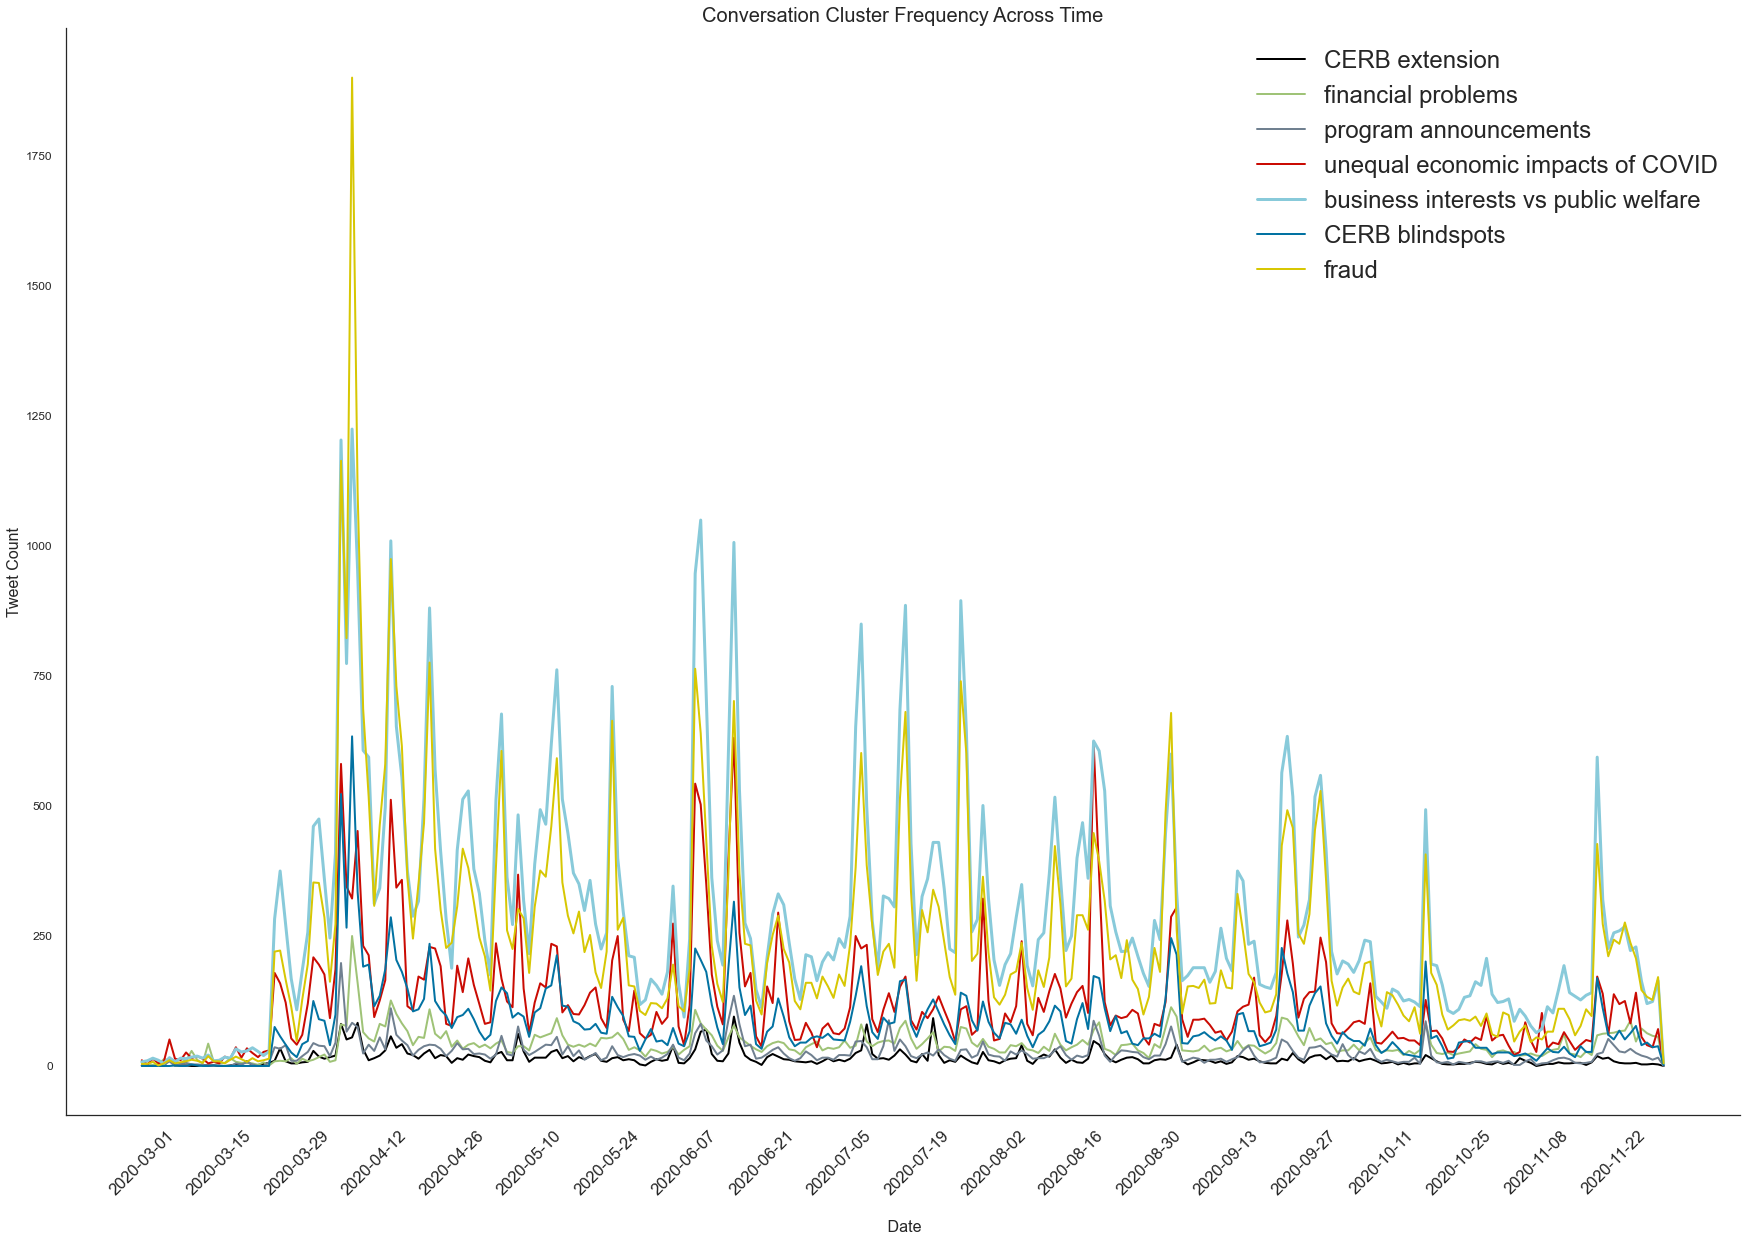

In [389]:
dates = date_freq.simple_date
x_ticks = list(date_freq.simple_date.unique()[::14])
# labels1 = ['March', 'Apr', 'May', 'June', 'July', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec']

zero = date_freq[0]
one = date_freq[1]
two = date_freq[2]
three = date_freq[3]
four = date_freq[4]
five = date_freq[5]
six = date_freq[6]


plt.figure(figsize=(30, 20))
plt.plot(dates, zero, color='black', linewidth=2, label='CERB extension')
plt.plot(dates, one, color='g', linewidth=2, label='financial problems')
plt.plot(dates, two, color='slategray', linewidth=2, label='program announcements')
plt.plot(dates, three, color='r', linewidth=2, label='unequal economic impacts of COVID')
plt.plot(dates, four, color='c', linewidth=3, label='business interests vs public welfare')
plt.plot(dates, five, color='b', linewidth=2, label='CERB blindspots')
plt.plot(dates, six, color='y', linewidth=2, label='fraud')


plt.title('Conversation Cluster Frequency Across Time', fontsize=20)
plt.xlabel('\n Date', fontsize=16)
plt.ylabel('Tweet Count', fontsize=16)
plt.xticks(x_ticks, rotation=45)
plt.legend(loc='upper right', frameon=False, fontsize=24)
sns.despine()
#plt.savefig('../img/top_freq_timeseries.png');

In [304]:
df1.iloc[33].vader_score

'Positive'

In [303]:
df1.iloc[33].content

"@mini_bubbly CONS weaponizing CERB like it's some horrible shameful thing. It's been a lifeline for so many who are facing terrible circumstances. It is incumbent upon a gov't to help its citizens during times like these. I haven't used CERB but I'm grateful it's there for others."

In [294]:
pos = df1[df1['vader_score']=='Positive']
neg = df1[df1['vader_score']=='Negative']
neut = df1[df1['vader_score']=='Neutral']

In [336]:
df1['vader_score'].value_counts(normalize=True)

Positive    0.414397
Negative    0.381395
Neutral     0.204208
Name: vader_score, dtype: float64

In [290]:
pos['km_label'].value_counts(normalize=True)

4    0.387659
6    0.314014
3    0.147992
5    0.070847
1    0.040933
2    0.024836
0    0.013720
Name: km_label, dtype: float64

In [291]:
neg['km_label'].value_counts(normalize=True)

4    0.411954
6    0.303167
3    0.157288
5    0.053138
1    0.034416
2    0.023159
0    0.016879
Name: km_label, dtype: float64

In [295]:
neut['km_label'].value_counts(normalize=True)

5    0.239614
6    0.227118
4    0.218503
3    0.129058
1    0.100449
2    0.056056
0    0.029201
Name: km_label, dtype: float64

Somewhat surprisingly, positive and negative tweets are grouped into the seven different clusters with nearly identical proportions while neutral tweets have a different distrubution.

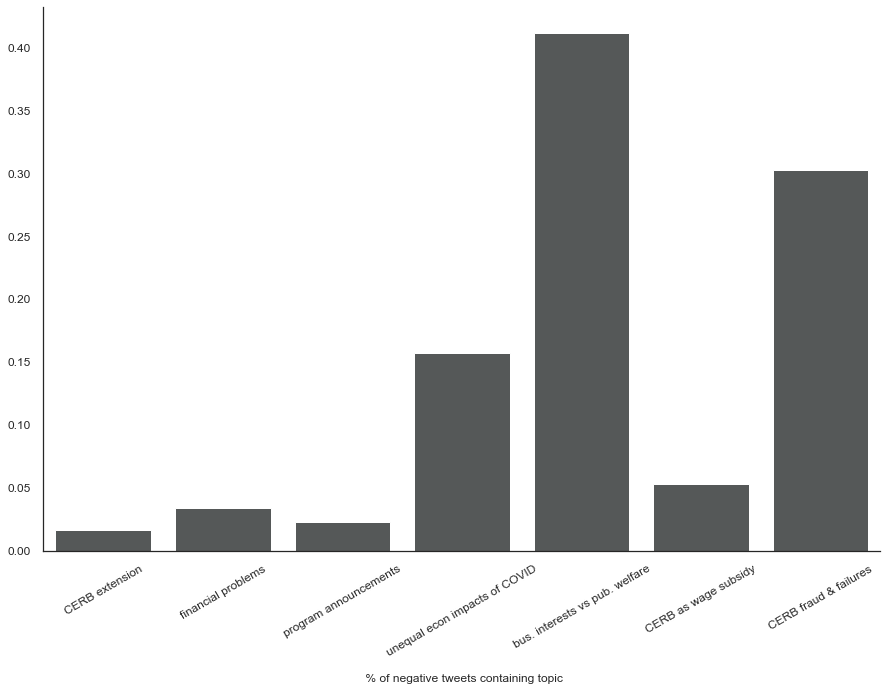

In [503]:
plt.figure(figsize=(15,10))
sns.barplot(x=neg['km_label'].value_counts().index, y= (neg['km_label'].value_counts(normalize=True)), data=neg,  palette=['#545859'])
plt.xlabel('\n % of negative tweets containing topic', fontsize=12)
plt.ylabel(None)
my_labels = ['CERB extension', 'financial problems', 'program announcements', 'unequal econ impacts of COVID', 'bus. interests vs pub. welfare', 'CERB as wage subsidy', 'CERB fraud & failures']
x_ticks = [0,1,2,3,4,5,6]
plt.xticks(x_ticks, labels=my_labels, rotation=30, size=12)
sns.despine();

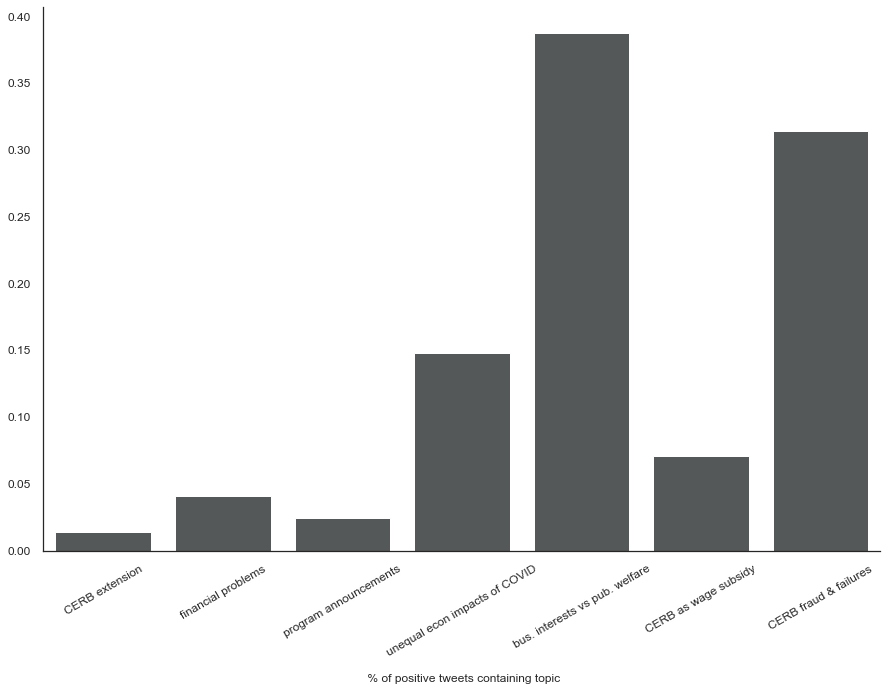

In [502]:
plt.figure(figsize=(15,10))
sns.barplot(x=pos['km_label'].value_counts().index, y= (pos['km_label'].value_counts(normalize=True)), data=pos,  palette=['#545859'])
plt.xlabel('\n % of positive tweets containing topic', fontsize=12)
plt.ylabel(None)
my_labels = ['CERB extension', 'financial problems', 'program announcements', 'unequal econ impacts of COVID', 'bus. interests vs pub. welfare', 'CERB as wage subsidy', 'CERB fraud & failures']
x_ticks = [0,1,2,3,4,5,6]
plt.xticks(x_ticks, labels=my_labels, rotation=30, size=12)
sns.despine();

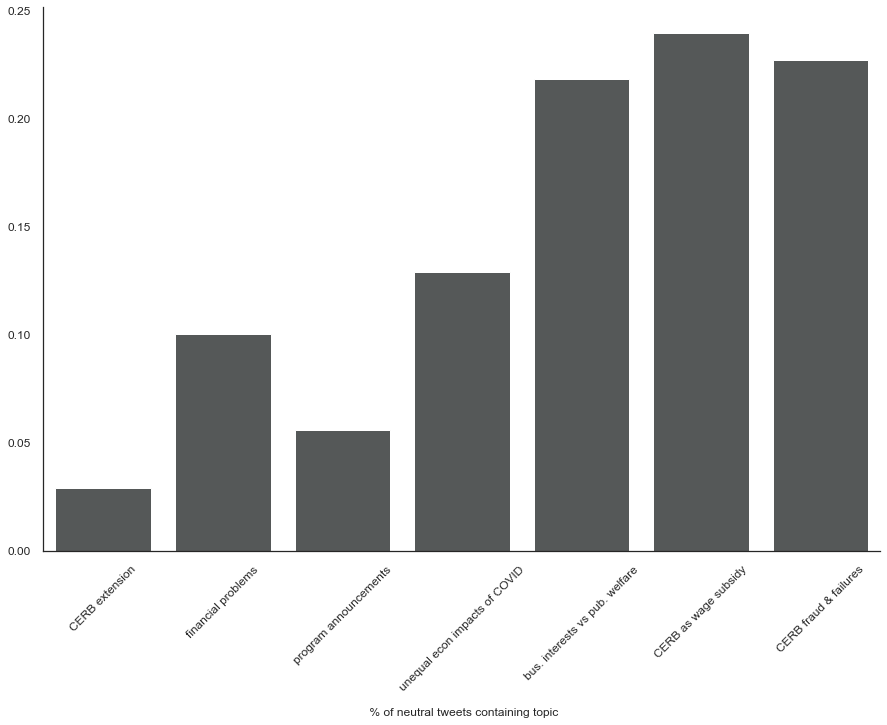

In [495]:
plt.figure(figsize=(15,10))
sns.barplot(x=neut['km_label'].value_counts().index, y= (neut['km_label'].value_counts(normalize=True)), data=neut,  palette=['#545859'])
plt.xlabel('\n % of neutral tweets containing topic', fontsize=12)
plt.ylabel(None)
my_labels = ['CERB extension', 'financial problems', 'program announcements', 'unequal econ impacts of COVID', 'bus. interests vs pub. welfare', 'CERB as wage subsidy', 'CERB fraud & failures']
x_ticks = [0,1,2,3,4,5,6]
plt.xticks(x_ticks, labels=my_labels, rotation=45, size=12)
sns.despine();

In [383]:
df1['km_label'].value_counts()

4    80947
6    65255
3    32986
5    22015
1    11303
2     6829
0     4040
Name: km_label, dtype: int64

In [379]:
df1.km_label.value_counts(normalize=True)

4    0.362382
6    0.292132
3    0.147671
5    0.098556
1    0.050601
2    0.030572
0    0.018086
Name: km_label, dtype: float64